## Testing VegAnn model on North Wycke farm images

In [1]:
!pip install torch
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install segmentation_models_pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pytorch_lightning as pl
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import matplotlib.pyplot as plt
from typing import Dict, List


In [3]:
# Define VegAnn Model
class VegAnnModel(pl.LightningModule):
    def __init__(self, arch: str, encoder_name: str, in_channels: int, out_classes: int, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.train_outputs, self.val_outputs, self.test_outputs = [], [], []

    def forward(self, image: torch.Tensor):
        # normalize image here #todo
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch: Dict, stage: str):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs: List[Dict], stage: str):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dataset_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        dataset_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_per_image_f1": per_image_f1,
            f"{stage}_dataset_f1": dataset_f1,
            f"{stage}_per_image_acc": per_image_acc,
            f"{stage}_dataset_acc": dataset_acc,
        }

        self.log_dict(metrics, prog_bar=True, sync_dist=True, rank_zero_only=True)

    def training_step(self, batch: Dict, batch_idx: int):
        step_outputs = self.shared_step(batch, "train")
        self.train_outputs.append(step_outputs)
        return step_outputs

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.train_outputs, "train")
        self.train_outputs = []

    def validation_step(self, batch: Dict, batch_idx: int):
        step_outputs = self.shared_step(batch, "valid")
        self.val_outputs.append(step_outputs)
        return step_outputs

    def on_validation_epoch_end(self, *args, **kwargs):
        self.shared_epoch_end(self.val_outputs, "valid")
        self.val_outputs = []

    def test_step(self, batch: Dict, batch_idx: int):
        step_outputs = self.shared_step(batch, "test")
        self.test_outputs.append(step_outputs)
        return step_outputs

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_outputs, "test")
        self.test_outputs = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [4]:
# Function for shading image with segmentation prediction
def colorTransform_VegGround(im,X_true,alpha_vert,alpha_g):
    alpha = alpha_vert
    color = [97,65,38]
    image=np.copy(im)
    for c in range(3):
        image[:, :, c] =np.where(X_true == 0,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    alpha = alpha_g
    color = [34,139,34]
    for c in range(3):
        image[:, :, c] =np.where(X_true == 1,image[:, :, c] *(1 - alpha) + alpha * color[c] ,image[:, :, c])
    return image

In [5]:
# Download model weights
!gdown https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
ckt_path = "/content/VegAnn.ckpt"
checkpoint = torch.load(ckt_path, map_location=torch.device('cpu'))


Downloading...
From (original): https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw
From (redirected): https://drive.google.com/uc?id=1azagsinfW4btSGaTi0XJKsRnFR85Gtaw&confirm=t&uuid=0ee6a955-56a2-4f97-b216-f057eef631c8
To: /content/VegAnn.ckpt
100% 294M/294M [00:11<00:00, 24.7MB/s]


### Test generic model (single output: vegetation vs background)

In [10]:
# Single class output

from torchsummary import summary

model = VegAnnModel("Unet","resnet34", in_channels = 3, out_classes=1)
model.load_state_dict(checkpoint["state_dict"])
preprocess_fn = smp.encoders.get_preprocessing_fn("resnet34", pretrained= "imagenet")
summary(model, input_size=(3, 512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [7]:
# Download Maxwell example image from roboflow (downloaded on 3/7/24)
!wget https://source.roboflow.com/lIFuTMYTdDcb4wAHWf9A4cSE6kn1/xdKM4CMqQm90sy0wu22G/original.jpg
image_name = 'original.jpg'

--2024-07-04 13:37:24--  https://source.roboflow.com/lIFuTMYTdDcb4wAHWf9A4cSE6kn1/xdKM4CMqQm90sy0wu22G/original.jpg
Resolving source.roboflow.com (source.roboflow.com)... 35.190.21.63
Connecting to source.roboflow.com (source.roboflow.com)|35.190.21.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16854217 (16M) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>]  16.07M  26.5MB/s    in 0.6s    

2024-07-04 13:37:25 (26.5 MB/s) - ‘original.jpg’ saved [16854217/16854217]



In [8]:
demo_image_cv2 = cv2.imread(image_name)
print(f"Image shape = {demo_image_cv2.shape}")

Image shape = (3840, 5760, 3)


In [9]:
width = demo_image_cv2.shape[0]
height = demo_image_cv2.shape[1]
scale_factor = 5
demo_image_resized = cv2.resize(demo_image_cv2, (height//scale_factor, width//scale_factor))
print(f"Image shape = {demo_image_resized.shape}")

Image shape = (768, 1152, 3)


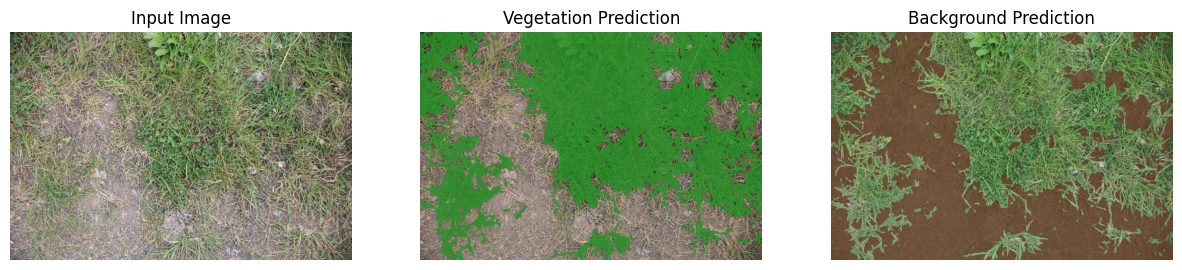

In [ ]:
# Test VegAnn general (single class) prediction on demo image
im = cv2.cvtColor(demo_image_resized, cv2.COLOR_BGR2RGB)

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
image = preprocess_input(im)
image = image.astype('float32')

inputs = torch.tensor(image) # , dtype=float
inputs = inputs.permute(2,0,1)
inputs = inputs[None,:,:,:]
logits = model(inputs)
pr_mask = logits.sigmoid()

pred = (pr_mask > 0.5).numpy().astype(np.uint8)

im1_pred = colorTransform_VegGround(im,pred,0.8,0.2)
im2_pred = colorTransform_VegGround(im,pred,0.2,0.8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
ax1.imshow(im)
ax1.set_title("Input Image")

ax2.imshow(im2_pred)
ax2.set_title("Vegetation Prediction")

ax3.imshow(im1_pred)
ax3.set_title("Background Prediction")

for ax in (ax1, ax2, ax3):
  ax.axis('off')

plt.show()

### Test VegAnn model with the 27 different classes

In [ ]:
# Single class output

model = VegAnnModel("Unet","resnet34", in_channels = 3, out_classes=1)
model.load_state_dict(checkpoint["state_dict"])
preprocess_fn = smp.encoders.get_preprocessing_fn("resnet34", pretrained= "imagenet")
print(model)